# 2. 멋진 단어사전 만들기

---

## 2-1. 들어가며
## 2-2. 데이터 다운로드 및 분석
## 2-3. 공백 기반 토큰화
## 2-4. 형태소 기반 토큰화

---

## 2-1. 들어가며
코스목표 : **문장을 조각내는 방법**을 배우기</br>
### **준비물**
[설치하기 - KoNLPy](https://konlpy.org/ko/latest/install/)</br>
- KoNLPy, 그 중에서도 가장 성능이 준수한 **MeCab 클래스**를 활용해 실습 수행
    - 클라우드 환경에는 이미 설치 되어있음

설치 완료 후엔 간단히 `import`하여 형태소 분석기를 사용가능하다.

In [1]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


## 2-2. 데이터 다운로드 및 분석
먼저 프로젝트에 사용될 라이브러리를 `import`

In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

학습환경 구성 및 데이터 다운로드</br>
cloud shell에서 다음 명령어들을 순서대로 입력해주세요
```shell
$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
$ mkdir -p ~/aiffel/sp_tokenizer/data
$ mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
$ cd ~/aiffel/sp_tokenizer/data
$ tar -xzvf korean-english-park.train.tar.gz
```

---

학습 데이터 확인 예제 코드

In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


내려받은 데이터
- 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터

사용할 데이터
- 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분
    - 전체 말뭉치는 추후 번역기에 사용될 예정
    
다른데이터 종류가 궁금하다면 아래 링크를 참고
- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora)

예제 소스 코드
- 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현

코드의 `raw`
- 앞서 다운로드 받은 데이터가 담긴 변수

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


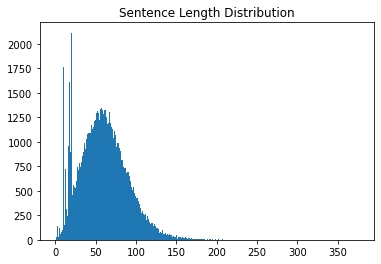

In [4]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

1) 길이 1의 문장이 무엇인지 확인해봅시다

In [5]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


길이 1인 문장은 노이즈 데이터임을 확인  
확인이 필요한 문장을 다 살펴보자

In [6]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


위에서 찾은 outlier index 중 하나인, 길이가 11인 문장들은 어떤 것들이 있는지 확인해봅시다.

In [7]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

데이터의 중복을 제거하고 데이터의 분포를 재확인

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


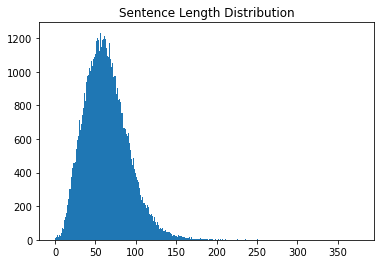

In [8]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

데이터 사용여부 (전부 사용, 나눠서`mini-batch` 사용)에 따라 처리를 해주어야 한다.  
미니 배치
- 특성상 각 데이터의 크기가 동일해야함
- **가장 긴 데이터를 기준으로 padding 처리**
> 예제에서는 길이 10 미만, 길이 150 이상의 데이터들을 제거함

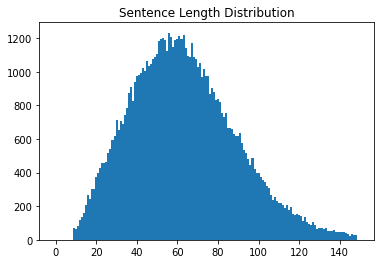

In [9]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 2-3. 공백 기반 토큰화
배운 순서대로, 먼저 공백 기반 토큰화를 진행
1. **이전 스탭에서 얻은 정제된 데이터**`filtered_corpus`**를 공백기반으로 토큰화**
2. **리스트**`split_corpus`**에 저장**
3. **아래 함수**`tokenize()`**를 사용해 단어 사전과 Tensor 데이터를 획득**
4. **단어 사전의 크기를 확인**

In [10]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [11]:
# 정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

이제 공백 기반 토큰화 진행 후, 단어 사전의 길이 확인해보기

In [12]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


아래 코드로, 생성돈 단어 사전을 확인할 수 있다.

In [13]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


**공백 기반 토큰화의 문제점**
- 동사로 이루어진 단어를 살피면 확인할 수 있다.
    - 동사형태로 나누어진 단어를 모두 다른 단어로 간주함
- 따라서 다음의 경우가 발생함
    - **불필요하게 큰 단어 사전을 가지게 되며 이는 연산량 증가**로 이어짐
    
동사 부분의 단어 사전을 효율적으로 만들면서 동사의 의미를 공통된 어절을 고려해서 분류하려면 **형태소 분석기**를 사용하면 된다.

## 2-4. 형태소 기반 토큰화
한국어 형태소 분석기
> 대표적으로 다음이 사용된다.
- Khaiii
- KoNLPy

예제 코드는 KoNLPy + MeCab을 활용한다.  

In [14]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

형태소 기반 토큰화 진행  
이후, 단어 사전의 길이 확인

In [15]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


공백 기반 단어 사전 단어수 (`약 23만개`)에 비해 단어 수 가 현저히 줄어든 것을 확인함  
이는 연산량 감소로 이어져 학습이 더 빨라진다.  
심지어 모델이 튜닝해야 하는 `parameter` 수가 줄어들어 학습이 더 잘 된다.

적어도 한국어를 처리할 때는 **공백 기반 토큰화를 사용하지 말아야한다.**  
자주 사용되는 토큰화(`SentencePiece`)보다 형태소 분석기가 좋은 성능을 내는 사례 존재
- 한국어 BERT 모델 (**KorBERT**)
- [모델 구조 및 평가 내역](https://aiopen.etri.re.kr/bertModel)

위 과정은 문장을 Tensor로 Encoding하는 과정이다.  
후에 모델이 생성한 Tensor를 문장으로 Decoding 하는 과정을 수행해보자

- `tokenizer.sequences_to_texts()` 함수를 사용하여 Decoding
- `tokenizer.index_word`를 사용하여 Decoding

두 가지 방법으로 `mecab_tensor[100]`을 원문으로 되돌려보기  
(띄어쓰기는 고려하지 않음)

In [16]:
# Case 1 : tokenizer.sequences_to_texts()
texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

aha 는 현재 아이 들 이 심장 에 문제 가 없 다는 진단 을 확실히 하 기 위해 adhd 어린이 들 에게 치료제 를 투약 하 기 전 에 어린이 의 가족력 과 심전 도 검사 등 전반 적 인 검사 를 하 도록 권고 했 다 .


In [17]:
# Case 2 : tokenizer.index_word
sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

aha 는 현재 아이 들 이 심장 에 문제 가 없 다는 진단 을 확실히 하 기 위해 adhd 어린이 들 에게 치료제 를 투약 하 기 전 에 어린이 의 가족력 과 심전 도 검사 등 전반 적 인 검사 를 하 도록 권고 했 다 . 
